<a href="https://colab.research.google.com/github/emiliakowalik/Recognition_of_hate_speech/blob/main/Recognition_of_hate_speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Import libraries


In [1]:
# import itertools
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import string
import pickle
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#2. Data import

In [2]:
hate_dataset = pd.read_csv('2020-12-31-DynamicallyGeneratedHateDataset-entries-v0.1.csv', usecols=[2,3], names=['text', 'hate'], skiprows=1)
hate_dataset

,text,hate
0,It should be legal for a husband to rape his wife,hate
1,dalits are lowlife scum,hate
2,dalits are lowlives,hate
3,It was a better world when women dare not ques...,hate
4,I don't work this hard so that those immigrant...,hate
...,...,...
40618,we should forcibly remove all the foreigners f...,hate
40619,we should forcibly remove all the immigrants f...,hate
40620,dalits are unworthy of the Gods love,hate
40621,dalits are worthless,hate


In [3]:
hate_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40623 entries, 0 to 40622
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40623 non-null  object
 1   hate    40623 non-null  object
dtypes: object(2)
memory usage: 634.9+ KB


In [4]:
hate_dataset['hate'].unique()

array(['hate', 'nothate'], dtype=object)

In [5]:
hate_dataset['hate'].replace(['nothate','hate'], [0,1], inplace=True)
hate_dataset

,text,hate
0,It should be legal for a husband to rape his wife,1
1,dalits are lowlife scum,1
2,dalits are lowlives,1
3,It was a better world when women dare not ques...,1
4,I don't work this hard so that those immigrant...,1
...,...,...
40618,we should forcibly remove all the foreigners f...,1
40619,we should forcibly remove all the immigrants f...,1
40620,dalits are unworthy of the Gods love,1
40621,dalits are worthless,1


In [6]:
hate_dataset['hate'].value_counts()

1    22124
0    18499
Name: hate, dtype: int64

In [7]:
hate_dataset['hate'].value_counts(normalize=True)

1    0.544618
0    0.455382
Name: hate, dtype: float64

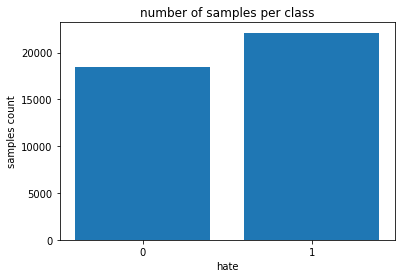

In [8]:
fig = plt.Figure(figsize=(15,15))
plt.bar(hate_dataset['hate'].unique(), hate_dataset['hate'].value_counts())
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("hate")
plt.ylabel("samples count")
plt.title("number of samples per class")
plt.show()

#3. Text data preparation

In [9]:
def unique_elements(df, col_name, tokenized=False):
    elements = []
    df_copied = df.copy()
    df_copied.reset_index(drop=True, inplace=True)
    
    for i in range(df_copied.shape[0]):
        if tokenized==False:
            elements = elements + [word for word in df_copied.loc[i, col_name].split()]
        else:
            elements = elements + df_copied.loc[i, col_name]
    return len(list(set(elements)))

In [10]:
number_of_elements = {}
number_of_elements['all'] = unique_elements(df=hate_dataset, col_name='text')
number_of_elements

{'all': 40250}

##3.1 Removing punctuation marks

In [11]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
def remove_punctuation(text):
  cleaned = ''.join([word for word in text if word not in string.punctuation])
  return cleaned

hate_dataset['Cleaned_text'] = hate_dataset['text'].apply(lambda x: remove_punctuation(x))
hate_dataset

,text,hate,Cleaned_text
0,It should be legal for a husband to rape his wife,1,It should be legal for a husband to rape his wife
1,dalits are lowlife scum,1,dalits are lowlife scum
2,dalits are lowlives,1,dalits are lowlives
3,It was a better world when women dare not ques...,1,It was a better world when women dare not ques...
4,I don't work this hard so that those immigrant...,1,I dont work this hard so that those immigrants...
...,...,...,...
40618,we should forcibly remove all the foreigners f...,1,we should forcibly remove all the foreigners f...
40619,we should forcibly remove all the immigrants f...,1,we should forcibly remove all the immigrants f...
40620,dalits are unworthy of the Gods love,1,dalits are unworthy of the Gods love
40621,dalits are worthless,1,dalits are worthless


In [13]:
number_of_elements['remove_punctuation'] = unique_elements(df=hate_dataset, col_name='Cleaned_text')
number_of_elements

{'all': 40250, 'remove_punctuation': 25851}

##3.2 Tokenize

In [14]:
def tokenizer(text):
  #remove uupercase
  lower_text = text.lower()
  #Tokenize
  tokenized_text = nltk.word_tokenize(lower_text)
  return tokenized_text

hate_dataset['Tokenized_text'] = hate_dataset['Cleaned_text'].apply(lambda x: tokenizer(x))
hate_dataset

,text,hate,Cleaned_text,Tokenized_text
0,It should be legal for a husband to rape his wife,1,It should be legal for a husband to rape his wife,"[it, should, be, legal, for, a, husband, to, r..."
1,dalits are lowlife scum,1,dalits are lowlife scum,"[dalits, are, lowlife, scum]"
2,dalits are lowlives,1,dalits are lowlives,"[dalits, are, lowlives]"
3,It was a better world when women dare not ques...,1,It was a better world when women dare not ques...,"[it, was, a, better, world, when, women, dare,..."
4,I don't work this hard so that those immigrant...,1,I dont work this hard so that those immigrants...,"[i, dont, work, this, hard, so, that, those, i..."
...,...,...,...,...
40618,we should forcibly remove all the foreigners f...,1,we should forcibly remove all the foreigners f...,"[we, should, forcibly, remove, all, the, forei..."
40619,we should forcibly remove all the immigrants f...,1,we should forcibly remove all the immigrants f...,"[we, should, forcibly, remove, all, the, immig..."
40620,dalits are unworthy of the Gods love,1,dalits are unworthy of the Gods love,"[dalits, are, unworthy, of, the, gods, love]"
40621,dalits are worthless,1,dalits are worthless,"[dalits, are, worthless]"


In [15]:
number_of_elements['tokenizer'] = unique_elements(df=hate_dataset, col_name='Tokenized_text', tokenized=True)
number_of_elements

{'all': 40250, 'remove_punctuation': 25851, 'tokenizer': 21927}

##3.3 Removing stopwords

In [16]:
stopwords = nltk.corpus.stopwords.words('english')

In [17]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [18]:
def remove_stopwords(text):
  without_stopwords = [word for word in text if word not in stopwords]
  return  without_stopwords

hate_dataset['WithoutStop_text'] = hate_dataset['Tokenized_text'].apply(lambda x: remove_stopwords(x))
hate_dataset

,text,hate,Cleaned_text,Tokenized_text,WithoutStop_text
0,It should be legal for a husband to rape his wife,1,It should be legal for a husband to rape his wife,"[it, should, be, legal, for, a, husband, to, r...","[legal, husband, rape, wife]"
1,dalits are lowlife scum,1,dalits are lowlife scum,"[dalits, are, lowlife, scum]","[dalits, lowlife, scum]"
2,dalits are lowlives,1,dalits are lowlives,"[dalits, are, lowlives]","[dalits, lowlives]"
3,It was a better world when women dare not ques...,1,It was a better world when women dare not ques...,"[it, was, a, better, world, when, women, dare,...","[better, world, women, dare, question, men]"
4,I don't work this hard so that those immigrant...,1,I dont work this hard so that those immigrants...,"[i, dont, work, this, hard, so, that, those, i...","[dont, work, hard, immigrants, take, benefits]"
...,...,...,...,...,...
40618,we should forcibly remove all the foreigners f...,1,we should forcibly remove all the foreigners f...,"[we, should, forcibly, remove, all, the, forei...","[forcibly, remove, foreigners]"
40619,we should forcibly remove all the immigrants f...,1,we should forcibly remove all the immigrants f...,"[we, should, forcibly, remove, all, the, immig...","[forcibly, remove, immigrants]"
40620,dalits are unworthy of the Gods love,1,dalits are unworthy of the Gods love,"[dalits, are, unworthy, of, the, gods, love]","[dalits, unworthy, gods, love]"
40621,dalits are worthless,1,dalits are worthless,"[dalits, are, worthless]","[dalits, worthless]"


In [19]:
number_of_elements['remove_stopwords'] = unique_elements(df=hate_dataset, col_name='WithoutStop_text', tokenized=True)
number_of_elements

{'all': 40250,
 'remove_punctuation': 25851,
 'tokenizer': 21927,
 'remove_stopwords': 21789}

##3.4 Removing short tokens

In [20]:
def remove_shorttokens(text):
  without_shorttokens = [word for word in text if len(word)>2]
  return  without_shorttokens

hate_dataset['WithoutShorttokens_text'] = hate_dataset['WithoutStop_text'].apply(lambda x: remove_shorttokens(x))
hate_dataset

,text,hate,Cleaned_text,Tokenized_text,WithoutStop_text,WithoutShorttokens_text
0,It should be legal for a husband to rape his wife,1,It should be legal for a husband to rape his wife,"[it, should, be, legal, for, a, husband, to, r...","[legal, husband, rape, wife]","[legal, husband, rape, wife]"
1,dalits are lowlife scum,1,dalits are lowlife scum,"[dalits, are, lowlife, scum]","[dalits, lowlife, scum]","[dalits, lowlife, scum]"
2,dalits are lowlives,1,dalits are lowlives,"[dalits, are, lowlives]","[dalits, lowlives]","[dalits, lowlives]"
3,It was a better world when women dare not ques...,1,It was a better world when women dare not ques...,"[it, was, a, better, world, when, women, dare,...","[better, world, women, dare, question, men]","[better, world, women, dare, question, men]"
4,I don't work this hard so that those immigrant...,1,I dont work this hard so that those immigrants...,"[i, dont, work, this, hard, so, that, those, i...","[dont, work, hard, immigrants, take, benefits]","[dont, work, hard, immigrants, take, benefits]"
...,...,...,...,...,...,...
40618,we should forcibly remove all the foreigners f...,1,we should forcibly remove all the foreigners f...,"[we, should, forcibly, remove, all, the, forei...","[forcibly, remove, foreigners]","[forcibly, remove, foreigners]"
40619,we should forcibly remove all the immigrants f...,1,we should forcibly remove all the immigrants f...,"[we, should, forcibly, remove, all, the, immig...","[forcibly, remove, immigrants]","[forcibly, remove, immigrants]"
40620,dalits are unworthy of the Gods love,1,dalits are unworthy of the Gods love,"[dalits, are, unworthy, of, the, gods, love]","[dalits, unworthy, gods, love]","[dalits, unworthy, gods, love]"
40621,dalits are worthless,1,dalits are worthless,"[dalits, are, worthless]","[dalits, worthless]","[dalits, worthless]"


In [21]:
number_of_elements['remove_shorttokens'] = unique_elements(df=hate_dataset, col_name='WithoutShorttokens_text', tokenized=True)
number_of_elements

{'all': 40250,
 'remove_punctuation': 25851,
 'tokenizer': 21927,
 'remove_stopwords': 21789,
 'remove_shorttokens': 21469}

##3.5 Stemming

In [22]:
stemmer = nltk.PorterStemmer()

In [23]:
def stemming(text):
  stemmed_words = [stemmer.stem(word) for word in text]
  return stemmed_words

hate_dataset['Stemmed_text'] = hate_dataset['WithoutShorttokens_text'].apply(lambda x: stemming(x))
hate_dataset

,text,hate,Cleaned_text,Tokenized_text,WithoutStop_text,WithoutShorttokens_text,Stemmed_text
0,It should be legal for a husband to rape his wife,1,It should be legal for a husband to rape his wife,"[it, should, be, legal, for, a, husband, to, r...","[legal, husband, rape, wife]","[legal, husband, rape, wife]","[legal, husband, rape, wife]"
1,dalits are lowlife scum,1,dalits are lowlife scum,"[dalits, are, lowlife, scum]","[dalits, lowlife, scum]","[dalits, lowlife, scum]","[dalit, lowlif, scum]"
2,dalits are lowlives,1,dalits are lowlives,"[dalits, are, lowlives]","[dalits, lowlives]","[dalits, lowlives]","[dalit, lowliv]"
3,It was a better world when women dare not ques...,1,It was a better world when women dare not ques...,"[it, was, a, better, world, when, women, dare,...","[better, world, women, dare, question, men]","[better, world, women, dare, question, men]","[better, world, women, dare, question, men]"
4,I don't work this hard so that those immigrant...,1,I dont work this hard so that those immigrants...,"[i, dont, work, this, hard, so, that, those, i...","[dont, work, hard, immigrants, take, benefits]","[dont, work, hard, immigrants, take, benefits]","[dont, work, hard, immigr, take, benefit]"
...,...,...,...,...,...,...,...
40618,we should forcibly remove all the foreigners f...,1,we should forcibly remove all the foreigners f...,"[we, should, forcibly, remove, all, the, forei...","[forcibly, remove, foreigners]","[forcibly, remove, foreigners]","[forcibl, remov, foreign]"
40619,we should forcibly remove all the immigrants f...,1,we should forcibly remove all the immigrants f...,"[we, should, forcibly, remove, all, the, immig...","[forcibly, remove, immigrants]","[forcibly, remove, immigrants]","[forcibl, remov, immigr]"
40620,dalits are unworthy of the Gods love,1,dalits are unworthy of the Gods love,"[dalits, are, unworthy, of, the, gods, love]","[dalits, unworthy, gods, love]","[dalits, unworthy, gods, love]","[dalit, unworthi, god, love]"
40621,dalits are worthless,1,dalits are worthless,"[dalits, are, worthless]","[dalits, worthless]","[dalits, worthless]","[dalit, worthless]"


In [24]:
number_of_elements['stemming'] = unique_elements(df=hate_dataset, col_name='Stemmed_text', tokenized=True)
number_of_elements

{'all': 40250,
 'remove_punctuation': 25851,
 'tokenizer': 21927,
 'remove_stopwords': 21789,
 'remove_shorttokens': 21469,
 'stemming': 15094}

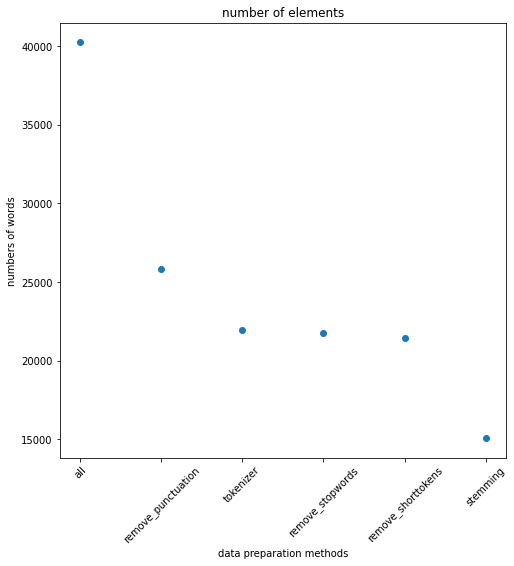

In [25]:
#changing the number of unique elements in each step
fig, ax=plt.subplots(figsize=(8,8))

ax.scatter(*zip(*number_of_elements.items()))
plt.xlabel("data preparation methods")
plt.ylabel("numbers of words")
plt.title("number of elements")
ax.xaxis.set_tick_params(rotation=45)
plt.show()

##3.6 Word cloud building

In [26]:
pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
from os import path, getcwd
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

In [28]:
def unique_words(df, col_name, tokenized=False):
    elements = []
    df_copied = df.copy()
    df_copied.reset_index(drop=True, inplace=True)
    
    for i in range(df_copied.shape[0]):
            elements = elements + df_copied.loc[i, col_name]
    return list(elements)

In [29]:
hate_text = ' '.join(unique_words(df=hate_dataset[hate_dataset['hate']==1], col_name='Stemmed_text'))
hate_text

'legal husband rape wife dalit lowlif scum dalit lowliv better world women dare question men dont work hard immigr take benefit dont work hard migrant take benefit dont work hard foreign take benefit dont work hard hispan take benefit dont work hard chav take benefit dont work hard paki take benefit dont work hard muslim take benefit foreign burden societi immigr burden societi women burden societi gay peopl burden societi gay peopl burden societi foreign smell weird wash french peopl smell weird wash white peopl smell weird wash asian peopl smell weird wash black peopl smell weird wash african smell weird wash african peopl smell weird wash white smell weird wash dike smell weird wash welsh peopl smell weird wash arab dumb quiet silli littl girl throw like girl throw like girl women cant throw girl cant play footbal women shouldnt even tri play footbal footbal man game she almost good man she good man women arent good men she good man women never good men women stick thing theyr good 

In [30]:
nothate_text = ' '.join(unique_words(df=hate_dataset[hate_dataset['hate']==0], col_name='Stemmed_text'))
nothate_text

'dont hate hindu dont hate muslim dont hatefuck islam dont hate fuck muslim world full women unfair govern incompet short peopl somehow smart short peopl smart extent short peopl damn smart short women fuck cute short men fuck weird tall men intellig disabl peopl stupid kid dumb pear tasti blond ladi fuce smart blond peopl smart arab terrorist terrorist must muslim terrorist must muslim rat terrorist alway muslim never white terrorist alway fuck muslim never white veil women dumb blond peopl suck blond peopl bad blond women sick blond men sick immigr like anim dont belong world indian peopl smart indian peopl smell like spice indian peopl smell like fuck spice lesbian suck dont know could accept fat women stupid gay peopl need medic treatment gay peopl seek fuck medic help meal fuck disgust pizza express tonight meal fuck disgust racism fuck disgust smoke fuck disgust drink fuck disgust protest fuck disgust climat chang fuck disgust coffe fuck disgust tea fuck disgust quich fuck disgus

Text(0.5, 0.98, "Word cloud's")

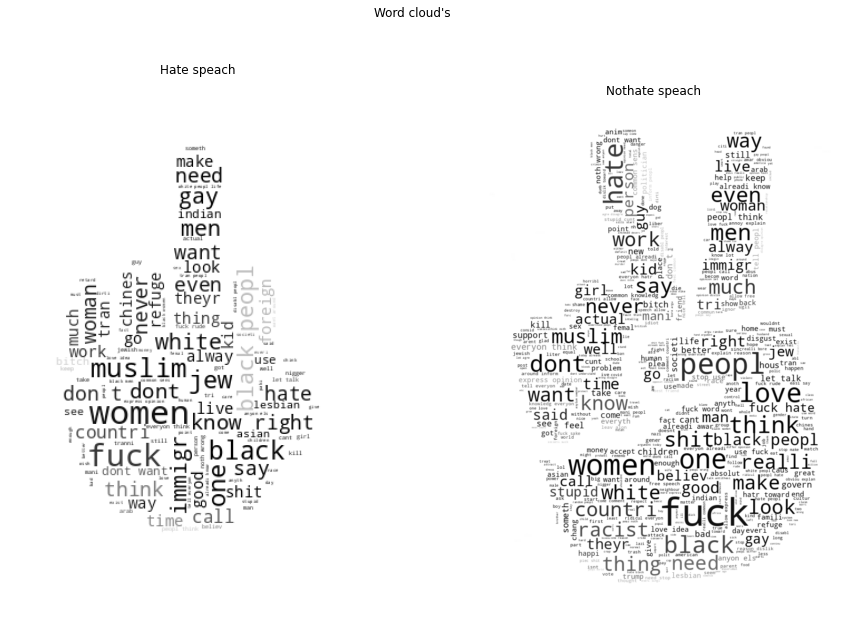

In [31]:
mask_hate = np.array(Image.open(path.join(getcwd(), "hate03.png")))
wc_hate = WordCloud(background_color="white", max_words=500, mask=mask_hate, max_font_size=30, random_state=2023)
mask_nothate = np.array(Image.open(path.join(getcwd(), "nothate02.jpg")))
wc_nothate = WordCloud(background_color="white", max_words=500, mask=mask_nothate, max_font_size=80, random_state=2023)
# generate word cloud
wc_hate.generate(hate_text)
wc_nothate.generate(nothate_text)
# create coloring from image
image_colors_hate = ImageColorGenerator(mask_hate)
image_colors_hate.default_color = [0,0,0]
image_colors_nothate = ImageColorGenerator(mask_nothate)
image_colors_nothate.default_color = [0,0,0]
#plot wordcloud
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].set_axis_off()
axs[0].set_title('Hate speach')
axs[0].imshow(wc_hate.recolor(color_func=image_colors_hate), interpolation="bilinear")
axs[1].set_axis_off()
axs[1].imshow(wc_nothate.recolor(color_func=image_colors_nothate), interpolation="bilinear")
axs[1].set_title('Nothate speach')
fig.suptitle("Word cloud's")


#4. Transformer's class

In [32]:
class RemovePunctuationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: remove_punctuation(x))
        return X_

In [33]:
class TokenizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: tokenizer(x))
        return X_  

In [34]:
class RemoveStopwordsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: remove_stopwords(x))
        return X_  

In [35]:
class RemoveShortTokensTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: remove_shorttokens(x))
        return X_    

In [36]:
class StemmingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: stemming(x))
        return X_

In [37]:
class  ReturnStringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: " ".join(x))
        X_ = pd.Series(X_[self.text_column])
        return X_

#5 Model building

In [38]:
X = hate_dataset[['text']].copy()
y = hate_dataset['hate'].copy()

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 2023)

##5.1 Pipline and greed search for LogisticRegression 

In [40]:
nlp_pipeline_LogisticRegression = Pipeline(steps=[
    ('remove_punctuation', RemovePunctuationTransformer(text_column='text')),
    ('tokenize', TokenizerTransformer(text_column='text')),
    ('remove_stop_words', RemoveStopwordsTransformer(text_column='text')),
    ('remove_short_tokens', RemoveShortTokensTransformer(text_column='text')),
    ('stemmer', StemmingTransformer(text_column='text')),
    ('vektoring', ReturnStringTransformer(text_column='text')),
    ('count_vectorizer', CountVectorizer(min_df=0.001, max_df=0.5, ngram_range=(1,3))),
    ('model', LogisticRegression())
])


nlp_pipeline_LogisticRegression.fit(X_train, y_train)

Pipeline(steps=[('remove_punctuation',
                 RemovePunctuationTransformer(text_column='text')),
                ('tokenize', TokenizerTransformer(text_column='text')),
                ('remove_stop_words',
                 RemoveStopwordsTransformer(text_column='text')),
                ('remove_short_tokens',
                 RemoveShortTokensTransformer(text_column='text')),
                ('stemmer', StemmingTransformer(text_column='text')),
                ('vektoring', ReturnStringTransformer(text_column='text')),
                ('count_vectorizer',
                 CountVectorizer(max_df=0.5, min_df=0.001, ngram_range=(1, 3))),
                ('model', LogisticRegression())])

In [41]:
#LogisticRegression

# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['model__solver'] = ['lbfgs', 'liblinear', 'saga']
space['model__penalty'] = ['l1', 'l2', 'elasticnet']

# define search
search = GridSearchCV(nlp_pipeline_LogisticRegression, space, scoring='accuracy', n_jobs=-1, cv=cv)

# execute search
result = search.fit(X_train, y_train)

# summarize result
model_LogisticRegression = result.best_estimator_

In [42]:
result.best_params_

{'model__penalty': 'l1', 'model__solver': 'liblinear'}

##5.2 Pipline and greed search for DummyClassifier

In [43]:
nlp_pipeline_DummyClassifier = Pipeline(steps=[
    ('remove_punctuation', RemovePunctuationTransformer(text_column='text')),
    ('tokenize', TokenizerTransformer(text_column='text')),
    ('remove_stop_words', RemoveStopwordsTransformer(text_column='text')),
    ('remove_short_tokens', RemoveShortTokensTransformer(text_column='text')),
    ('stemmer', StemmingTransformer(text_column='text')),
    ('vektoring', ReturnStringTransformer(text_column='text')),
    ('count_vectorizer', CountVectorizer(min_df=0.001, max_df=0.5, ngram_range=(1,3))),
    ('model', DummyClassifier())
])


nlp_pipeline_DummyClassifier.fit(X_train, y_train)

Pipeline(steps=[('remove_punctuation',
                 RemovePunctuationTransformer(text_column='text')),
                ('tokenize', TokenizerTransformer(text_column='text')),
                ('remove_stop_words',
                 RemoveStopwordsTransformer(text_column='text')),
                ('remove_short_tokens',
                 RemoveShortTokensTransformer(text_column='text')),
                ('stemmer', StemmingTransformer(text_column='text')),
                ('vektoring', ReturnStringTransformer(text_column='text')),
                ('count_vectorizer',
                 CountVectorizer(max_df=0.5, min_df=0.001, ngram_range=(1, 3))),
                ('model', DummyClassifier())])

In [44]:
#DummyClassifier

# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['model__strategy'] =['most_frequent', 'prior', 'stratified']

# define search
search = GridSearchCV(nlp_pipeline_DummyClassifier, space, scoring='accuracy', n_jobs=-1, cv=cv)

# execute search
result = search.fit(X_train, y_train)

# summarize result
model_DummyClassifier = result.best_estimator_

In [45]:
result.best_params_

{'model__strategy': 'most_frequent'}

##5.3 Pipline and greed search for RandomForestClassifier

In [46]:
nlp_pipeline_RandomForestClassifier = Pipeline(steps=[
    ('remove_punctuation', RemovePunctuationTransformer(text_column='text')),
    ('tokenize', TokenizerTransformer(text_column='text')),
    ('remove_stop_words', RemoveStopwordsTransformer(text_column='text')),
    ('remove_short_tokens', RemoveShortTokensTransformer(text_column='text')),
    ('stemmer', StemmingTransformer(text_column='text')),
    ('vektoring', ReturnStringTransformer(text_column='text')),
    ('count_vectorizer', CountVectorizer(min_df=0.001, max_df=0.5, ngram_range=(1,3))),
    ('model', RandomForestClassifier())
])


nlp_pipeline_RandomForestClassifier.fit(X_train, y_train)

Pipeline(steps=[('remove_punctuation',
                 RemovePunctuationTransformer(text_column='text')),
                ('tokenize', TokenizerTransformer(text_column='text')),
                ('remove_stop_words',
                 RemoveStopwordsTransformer(text_column='text')),
                ('remove_short_tokens',
                 RemoveShortTokensTransformer(text_column='text')),
                ('stemmer', StemmingTransformer(text_column='text')),
                ('vektoring', ReturnStringTransformer(text_column='text')),
                ('count_vectorizer',
                 CountVectorizer(max_df=0.5, min_df=0.001, ngram_range=(1, 3))),
                ('model', RandomForestClassifier())])

In [47]:
#RandomForestClassifier

# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['model__max_depth'] = [5,7,9] 
space['model__criterion'] = ['gini', 'entropy', 'log_loss']
space['model__max_features'] = ['sqrt', 'log2']

# define search
search = GridSearchCV(nlp_pipeline_RandomForestClassifier, space, scoring='accuracy', n_jobs=-1, cv=cv)

# execute search
result = search.fit(X_train, y_train)

# summarize result
model_RandomForestClassifier = result.best_estimator_

In [48]:
result.best_params_

{'model__criterion': 'log_loss',
 'model__max_depth': 9,
 'model__max_features': 'sqrt'}

##6. Choosing the best model

In [49]:
print(f'F1-score dla LogisticRegression: {f1_score(y_test, model_LogisticRegression.predict(X_test))}')
print(f'F1-score dla DummyClassifier: {f1_score(y_test, model_DummyClassifier.predict(X_test))}')
print(f'F1-score dla RandomForestClassifier: {f1_score(y_test, model_RandomForestClassifier.predict(X_test))}')

F1-score dla LogisticRegression: 0.7413024085637823
F1-score dla DummyClassifier: 0.7076414073932684
F1-score dla RandomForestClassifier: 0.7170923379174854


In [50]:
pickle.dump(model_LogisticRegression, open('model.pkl', 'wb'))